In [38]:
import pandas as pd
from Assemble_preprocess import *

movie_name = 'After_The_Rain_exp'
main_path = "/Volumes/LaCie/EPFL/Mastersem3/SemesterProjectND/DataframeX"
file_names = ["action_detection", "all_words", "all_transcriptions", "brightness_contrast_sharpness_data",
              "ColorDataframe", "frequency_time_series_data", "object_detection", "Scene_time_series",
              "texture_analysis_data", "all_phonems", "ZoomDetectionResults"]


########### 0 ########### ACTION

# use one hot labelling : 
df = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[0]+".csv")
# One-hot encode the 'Predicted Class' column
encoded_df_action = pd.get_dummies(df, columns=["Predicted Class"], prefix="action")

##### We skip alignments and transcriptions 

########### 3 ########### BRIGHTNESS

encoded_df_brightness = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[3]+".csv")


########### 4 ########### COLOR

encoded_df_color = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[4]+".csv")

########### 5 ########### FREQUENCY

encoded_df_frequency = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[5]+".csv")

########### 6 ########### OBJECT DETECTION

df_objects = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[6]+".csv")
# Convert the 'Detected Objects' column from string to dictionary
df_objects["Detected Objects"] = df_objects["Detected Objects"].apply(ast.literal_eval)

# Process the "Detected Objects" column
# Extract all unique object keys from the dictionary
unique_objects = set(
    obj for detected in df_objects["Detected Objects"] for obj in detected.keys()
)
# Create a new column for each object
for obj in unique_objects:
    df_objects["Object"+obj] = df_objects["Detected Objects"].apply(lambda x: x.get(obj, 0))
# Drop the original "Detected Objects" column if no longer needed
df_objects = df_objects.drop(columns=["Detected Objects"])
encoded_objects = df_objects.copy()



########### 7 ########### SCENE DETECTION


df_scene = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[7]+".csv")
df_scene = df_scene[["Time (s)", "Top Class"]]
# Use pd.get_dummies to create a column for each unique value in "Top Class"
encoded_scene = pd.get_dummies(df_scene["Top Class"], prefix="Scene")
# Combine the original DataFrame with the dummies
encoded_scene = pd.concat([df_scene, encoded_scene], axis=1)
# Drop the original "Top Class" column if no longer needed
encoded_scene = encoded_scene.drop(columns=["Top Class"])


########### 8 ########### TEXTURE ANALYSIS

encoded_df_texture = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[8]+".csv")
encoded_df_texture = encoded_df_texture.rename(columns={'Contrast': 'Texture contrast'})

########### 9 ########### ZOOM
encoded_df_zoom = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[-1]+".csv")



########### START MERGING PROCESS ###########

##### First merge :

# Merge both DataFrames on Timestamp (from action_df) and Time (s) (from brightness_df)
merged_df = pd.merge(encoded_df_brightness, encoded_df_action, right_on='Timestamp', left_on='Time (s)', how='left')

# Drop the 'Timestamp' column from the merged DataFrame, keeping 'Time (s)'
merged_df = merged_df.drop(columns=['Timestamp', 'Frame Index'])

##### Second merge :

merged_df2 = pd.merge(merged_df, encoded_df_color, right_on='Time (s)', left_on='Time (s)', how='left')
merged_df2 = merged_df2.drop(columns=['Frame Index'])


##### Third merge :

merged_df3 = pd.merge(merged_df2, encoded_df_frequency, right_on='Time (s)', left_on='Time (s)', how='left')


##### Fourth merge :

merged_df4 = pd.merge(merged_df3, encoded_objects, right_on='Time (s)', left_on='Time (s)', how='left')
merged_df4 = merged_df4.drop(columns=['Frame Index'])

##### Fifth merge :

merged_df5 = pd.merge(merged_df4, encoded_scene, right_on='Time (s)', left_on='Time (s)', how='left')

##### Sixth merge : 

merged_df6 = pd.merge(merged_df5, encoded_df_texture, right_on='Time (s)', left_on='Time (s)', how='left')
merged_df6 = merged_df6.drop(columns=['Frame Index'])


##### final merge on time (s) with zoomed in or not :

merged_df6 = pd.merge(merged_df6, encoded_df_zoom, right_on='Time (s)', left_on='Time (s)', how='left')
merged_df6 = merged_df6.drop(columns=['Frame Index'])


######## Final preprocessing :

# Convert all NaN values to 0
merged_df6 = merged_df6.fillna(0)

# Convert all True values to 1 and all False values to 0
merged_df6 = merged_df6.replace({True: 1, False: 0})


merged_df6 = merged_df6.drop_duplicates(subset=['Time (s)'])


####### Now the text Files!!
df_words = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[1]+".csv")
df_transcriptions = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[2]+".csv")
df_phonems = pd.read_csv(main_path+"/"+movie_name +"/"+file_names[-2]+".csv")

df_to_merge = merge_text(merged_df6, df_words)
merged_df_intermediate_1 = pd.merge(merged_df6, df_to_merge[['Time (s)', 'Words']], 
                      right_on='Time (s)', left_on='Time (s)', how='left')

df_to_merge2 = merge_text(merged_df_intermediate_1, df_phonems)
merged_df_intermediate_2 = pd.merge(merged_df_intermediate_1, df_to_merge2[['Time (s)', 'Phone']], 
                     right_on='Time (s)', left_on='Time (s)', how='left')

df_to_merge_final = merge_text(merged_df_intermediate_2, df_transcriptions)
merged_df7 = pd.merge(merged_df_intermediate_2, df_to_merge_final[['Time (s)', 'Sentence']], 
                     right_on='Time (s)', left_on='Time (s)', how='left')




##### Final DF to save as a csv file :
final_df = merged_df7.copy()
final_df = final_df.drop(columns=['Scene', 'Frame'])


final_df.to_csv(main_path+"/"+movie_name+"/Final_df2.csv", index=False)


/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_50141/3100700887.py:124: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df6 = merged_df6.replace({True: 1, False: 0})


In [39]:
final_df

,Time (s),Brightness Value,Contrast Value,Sharpness Value,action_abseiling,action_barbequing,action_beatboxing,action_belly dancing,action_bending metal,action_bungee jumping,...,Scene_water_tower,Scene_zen_garden,Texture contrast,Correlation,Energy,Homogeneity,Zoom,Words,Phone,Sentence
0,0.000000,171.759755,22.524308,3.223808,0,0,0,0,0,0,...,0,0,0.766025,0.999244,0.104449,0.832662,0,NaN,NaN,NaN
1,0.041708,171.764145,22.518452,3.243721,0,0,0,0,0,0,...,0,0,0.767887,0.999241,0.104364,0.832359,0,NaN,NaN,NaN
2,0.083417,171.423100,23.136726,4.438768,0,0,0,0,0,0,...,0,0,0.756565,0.999292,0.101422,0.820885,0,NaN,NaN,NaN
3,0.125125,171.030384,24.481179,5.114926,0,0,0,0,0,0,...,0,0,0.848120,0.999291,0.099708,0.819428,0,NaN,NaN,NaN
4,0.166833,170.362247,25.825103,5.629280,0,0,0,0,0,0,...,0,0,0.987639,0.999259,0.100664,0.826573,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,495.828667,53.438413,63.548736,1.889680,0,0,0,0,0,0,...,0,0,1.351918,0.999833,0.537500,0.850298,0,NaN,NaN,NaN
11889,495.870375,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0.000000,1.000000,1.000000,1.000000,0,NaN,NaN,NaN
11890,495.912083,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0.000000,1.000000,1.000000,1.000000,0,NaN,NaN,NaN
11891,495.953792,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0.000000,1.000000,1.000000,1.000000,0,NaN,NaN,NaN


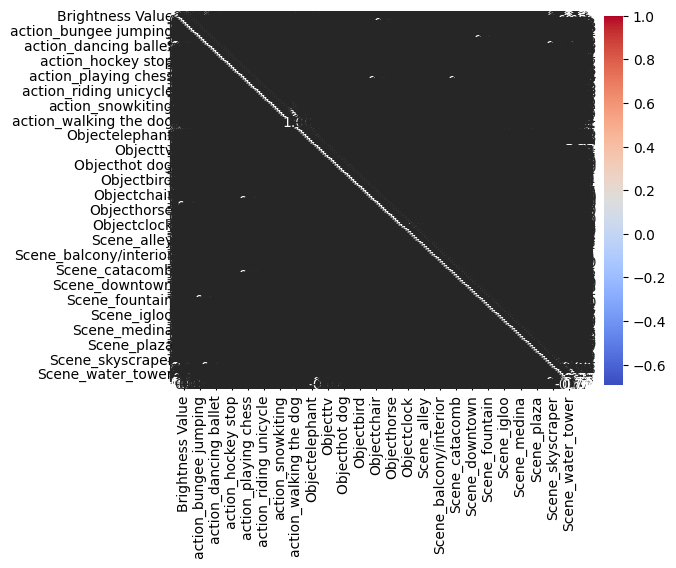

In [34]:
import pandas as pd

movie_name = 'After_The_Rain_exp'
main_path = "/Volumes/LaCie/EPFL/Mastersem3/SemesterProjectND/DataframeX"
file_names = ["action_detection", "all_words", "all_transcriptions", "brightness_contrast_sharpness_data",
              "ColorDataframe", "frequency_time_series_data", "object_detection", "Scene_time_series",
              "texture_analysis_data", "all_phonems"]

final_df = pd.read_csv(main_path+"/"+movie_name+"/Final_df2.csv")
final_df = final_df.drop(columns=['Time (s)', 'Sentence', 'Words', 'Phone'])



# Assuming X is a pandas DataFrame with your feature matrix
correlation_matrix = final_df.corr()

# To visualize the correlation matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()
